# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

In [ ]:
# !pip install -U gym==0.25.2
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[box2d]

In [8]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [4]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):
    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

def show_reward(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

## **Temporal Difference method**

Previously, we solved MDPs by means of the Monte Carlo method, which is a model-free approach that requires no prior knowledge of the environment. We will employ the **temporal difference (TD)** method in this chapter to solve this issue. In the TD method, we update the action values in every time step in an episode, which increases learning efficiency significantly.

As we saw for Monte Carlo methods, Prediction refers to the problem of estimating the values of states, **a value $V(s)$ of a state is an indication of how good is that state** for an agent in the given environment, the higher the value of the state the better it is to be in that state.

**Monte Carlo** methods wait until the return following the visit is known which is after the episode ends is available to update the value of the state.

$$
\large V(s_t) ← V(s_t) + \alpha[G_t- V(s_t)]
$$

whereas **TD methods** update the state value in the next time step, at the next time step t+1 they immediately form a target and make a useful update using the observed reward.

$$
\large V(s_t) ← V(s_t) + \alpha[R_{t+1} + \gamma V_(s_{t+1}) - V(s_t)]
$$

In the TD update equation, the quantity in brackets is a measure of an error, measuring the difference between the estimated value of St and the better estimate at the next time step. This quantity is called the TD error which has a widespread presence in all reinforcement learning.

$$
\large \delta \doteq R_{t+1} + \gamma V_(s_{t+1}) - V(s_t)
$$

Updating the state value just after one time step is called one-step TD or TD(0), In addition to that, TD methods are proven to be sound and guarantee convergence. For any fixed policy p, TD(0) has been proved to converge to the optimal value with probability 1 if the step-size parameter (alpha) decreases according to the usual stochastic approximation conditions.

**TD Control**
Control problem refers to the problem of estimating optimal policies, as with Monte Carlo methods we use the Generalized Policy Iteration for solving the control problem and similarly face the same trade-off between exploitation and exploration, as a solution to which our approach falls in either of the two categories: **on-policy** and **off-policy**.


## **Cliff Walking Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/cliff_walking.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(4)</td>
</tr>
<tr>
    <td><font size="3">Observation Space</td>
    <td><font size="3">Discrete(48))</td>
</tr>

<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("CliffWalking-v0")</code></td>
<tr>

In [32]:
env = create_env("CliffWalking-v0")

## **Developing the Q-learning algorithm**

Q-learning is an off-policy learning algorithm. It updates the Q-function based on the following equation:

<br>

$$
\large \textit{Q-learning algorithm} \\
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma max_{a'} Q(s', a') - Q(s, a)]
$$

<br>

Here, $s'$ is the resulting state after taking action, $a$, in state $s; r$ is the associated reward; $α$ is the learning rate; and $γ$ is the discount factor. Also, means that the behavior policy is greedy, where the highest Q-value among those in state s' is selected to generate learning data. In Q-learning, actions are taken according to the **epsilon-greedy policy**.

In [24]:
def gen_epsilon_greedy(n_action, epsilon):
    def policy(state, Q):
        prob = torch.ones(n_action) * (epsilon / n_action)
        best_action = torch.argmax(Q[state]).item()
        prob[best_action] += 1 - epsilon
        action = torch.multinomial(prob, 1).item()
        return action
    return policy

In [63]:
def q_learning(env, gamma, n_episode, alpha, epsilon):
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    epsilon_greedy = gen_epsilon_greedy(n_action, epsilon)
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode

    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = epsilon_greedy(state, Q)
            next_state, reward, done, _ = env.step(action)
            # Q learning
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta
            state = next_state

            length_episode[episode] += 1
            total_reward_episode[episode]+= reward

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()

    return Q, policy

In [64]:
env = create_env("CliffWalking-v0")
gamma = 1
n_episode = 500
alpha = 0.4
epsilon = 0.1
optimal_q, optimal_policy = q_learning(env, gamma, n_episode, alpha, epsilon)

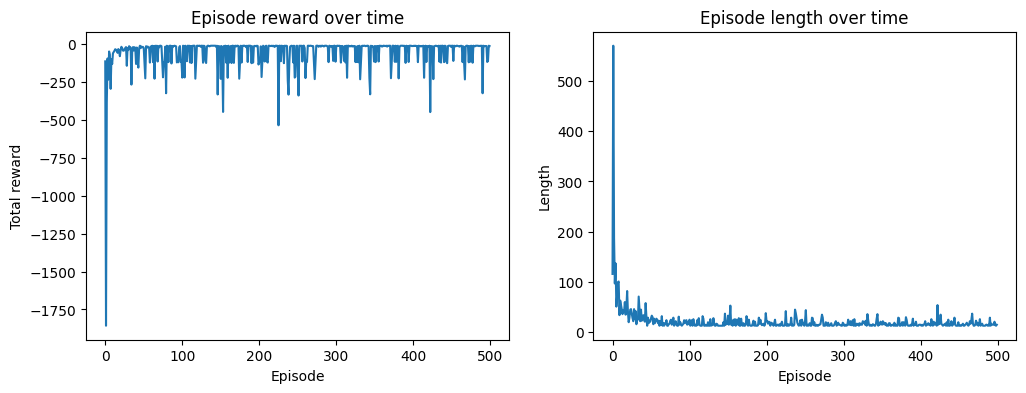

In [72]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

## **Developing the SARSA algorithm**

Similar to Q-learning, **State-Action-Reward-StateAction (SARSA)** focuses on state-action values. It updates the Q-function based on the following equation:

<br>

$$
\large \textit{SARSA algorithm} \\
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

Here, $s'$ is the resulting state after taking the action, $a$, in state $s; r$ is the associated reward; $α$ is the learning rate; and $γ$ is the discount factor.

In SARSA, we simply pick up the next action, $a'$, by also following an epsilon-greedy policy to update the Q value. And the action $a'$ is taken in the next step. Hence, SARSA is an on-policy algorithm.

In [76]:
def SARSA(env, gamma, n_episode, alpha, epsilon):
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    epsilon_greedy = gen_epsilon_greedy(n_action, epsilon)
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode

    for episode in range(n_episode):
        state = env.reset()
        done = False
        action = epsilon_greedy(state, Q)
        while not done:
            next_state, reward, done, _ = env.step(action)
            # Q learning
            next_action = epsilon_greedy(next_state, Q)
            td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * td_delta
            state = next_state
            action = next_action

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()

    return Q, policy

In [77]:
env = create_env("CliffWalking-v0")
gamma = 1
n_episode = 500
alpha = 0.4
epsilon = 0.1
optimal_q, optimal_policy = SARSA(env, gamma, n_episode, alpha, epsilon)

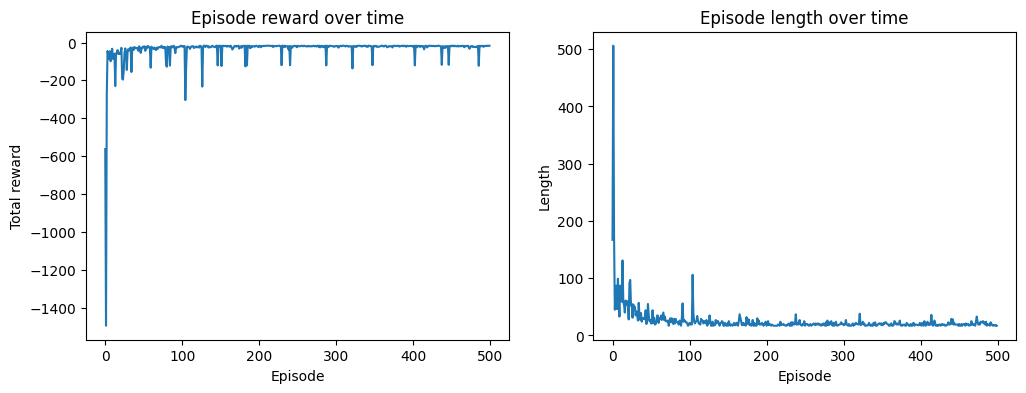

In [78]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [81]:
display_video(400)

## **Taxi Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/taxi.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(6)</td>
</tr>
<tr>
    <td><font size="3">Observation Space</td>
    <td><font size="3">Discrete(500))</td>
</tr>

<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("Taxi-v3")</code></td>
<tr>

In [84]:
env = create_env("Taxi-v3")
gamma = 1
n_episode = 500
alpha = 0.4
epsilon = 0.1
optimal_q, optimal_policy = q_learning(env, gamma, n_episode, alpha, epsilon)

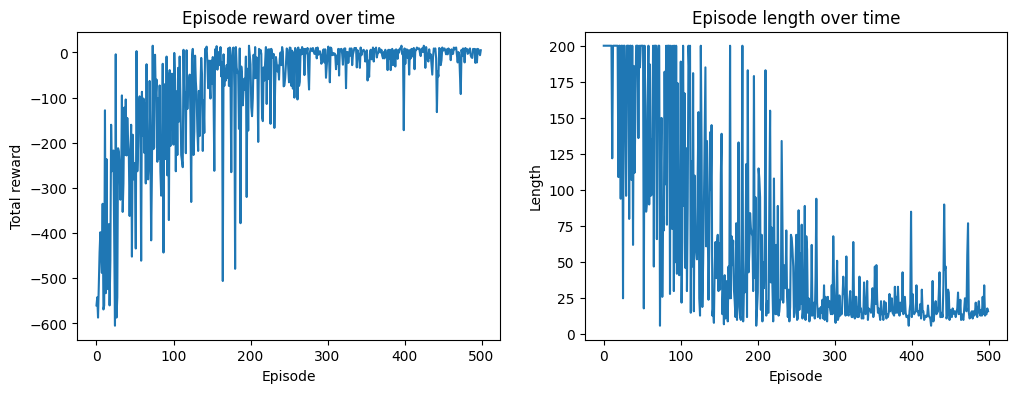

In [85]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [89]:
display_video(400)

In [90]:
env = create_env("Taxi-v3")
gamma = 1
n_episode = 500
alpha = 0.4
epsilon = 0.1
optimal_q, optimal_policy = SARSA(env, gamma, n_episode, alpha, epsilon)

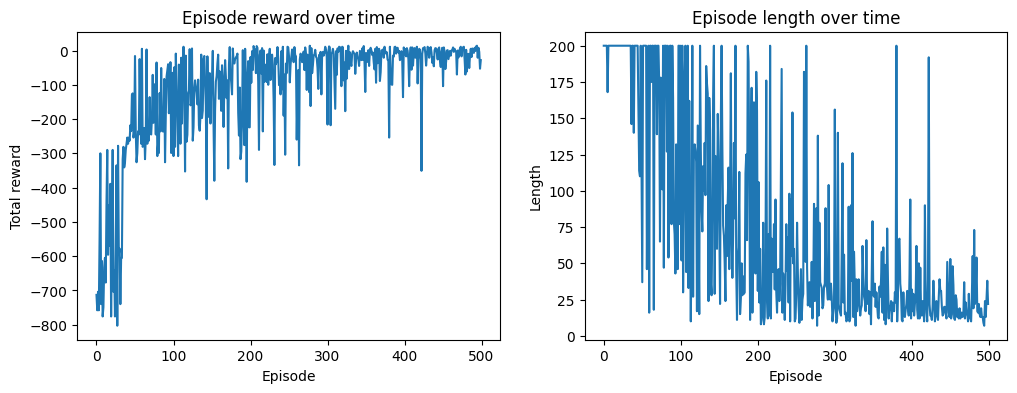

In [91]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [92]:
display_video(400)

## **Developing the Double Q-learning algorithm**

Q-learning is a powerful and popular TD control reinforcement learning algorithm. However, it may perform poorly in some cases, mainly because of the greedy component, $max_{a'}Q(s', a')$. It can overestimate action values and result in poor performance. Double Qlearning was invented to overcome this by utilizing two Q functions. We denote two Q functions as $Q_1$ and $Q_2$. In each step, one Q function is randomly selected to be updated. If $Q_1$ is selected, $Q_1$ is updated as follows:

<br>

$$
\large a^* = argmax_a Q_1(s', a),  \\
\\ \large Q_1(s, a) ← Q_1(s, a) + \alpha[r + \gamma Q_2(s', a^*) - Q_1(s, a)]
$$

<br>

If $Q_2$ is selected, it is updated as follows:

<br>

$$
\large a^* = argmax_a Q_2(s', a),  \\
\\ \large Q_2(s, a) ← Q_2(s, a) + \alpha[r + \gamma Q_1(s', a^*) - Q_2(s, a)]
$$

In [96]:
def double_q_learning(env, gamma, n_episode, alpha, epsilon):
    n_action = env.action_space.n
    n_state = env.observation_space.n
    Q1 = torch.zeros(n_state, n_action)
    Q2 = torch.zeros(n_state, n_action)
    epsilon_greedy = gen_epsilon_greedy(n_action, epsilon)
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode

    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = epsilon_greedy(state, Q1 + Q2)
            next_state, reward, done, _ = env.step(action)
            # Q learning
            if torch.rand(1).item() < 0.5:
                best_next_action = torch.argmax(Q1[next_state])
                td_delta = reward + gamma * Q2[next_state][best_next_action] - Q1[state][action]
                Q1[state][action] += alpha * td_delta
            else:
                best_next_action = torch.argmax(Q2[next_state])
                td_delta = reward + gamma * Q1[next_state][best_next_action] - Q2[state][action]
                Q2[state][action] += alpha * td_delta

            state = next_state

            length_episode[episode] += 1
            total_reward_episode[episode]+= reward

    policy = {}
    Q = Q1 + Q2
    for state in range(n_state):
        policy[state] = torch.argmax(Q[state]).item()

    return Q, policy

In [97]:
env = create_env("Taxi-v3")
gamma = 1
n_episode = 500
alpha = 0.4
epsilon = 0.1
optimal_q, optimal_policy = double_q_learning(env, gamma, n_episode, alpha, epsilon)

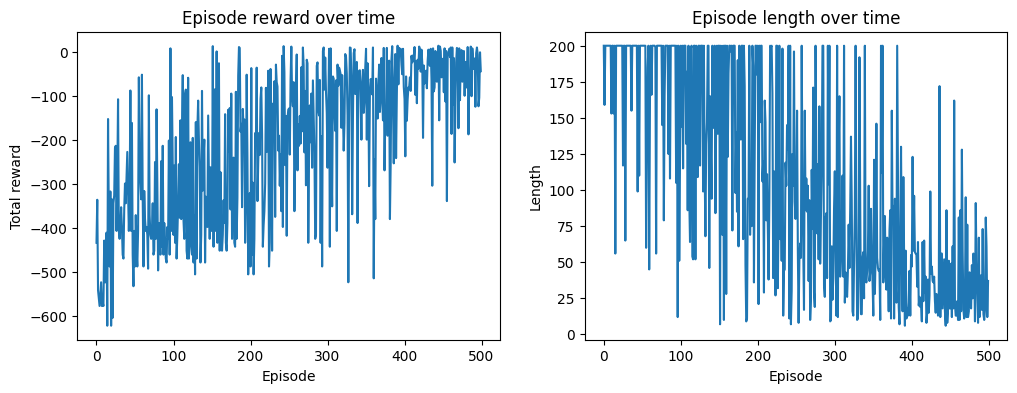

In [98]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [102]:
display_video(400)